[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
21:01:33 - cmdstanpy - INFO - Chain [1] start processing
21:01:36 - cmdstanpy - INFO - Chain [1] done processing


MAE: 6931.165571834077
MSE: 60770456.51892364
RMSE: 7795.540809906882


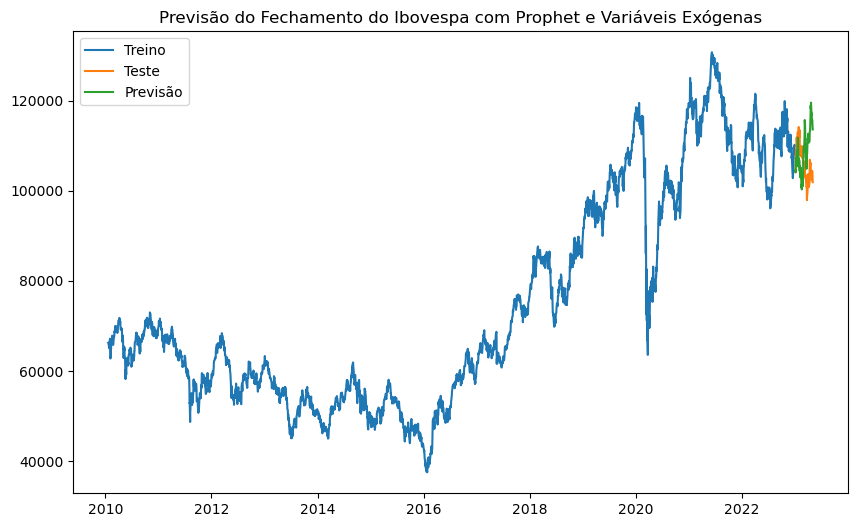

In [1]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Função para calcular o RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Baixar dados do Ibovespa e outras variáveis
ibov = yf.download('^BVSP', start='2010-01-01', end='2023-07-08')['Close']
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-07-08')['Close']  # S&P 500
usd_brl = yf.download('BRL=X', start='2010-01-01', end='2023-07-08')['Close']  # Taxa de câmbio USD/BRL
oil = yf.download('CL=F', start='2010-01-01', end='2023-07-08')['Close']  # Preço do petróleo

# Criar um DataFrame com o índice de datas comuns
dates = ibov.index

# Reindexar todas as séries para ter as mesmas datas
sp500 = sp500.reindex(dates)
usd_brl = usd_brl.reindex(dates)
oil = oil.reindex(dates)

# Calcular o RSI para o Ibovespa
rsi_ibov = calculate_rsi(ibov, 14).reindex(dates)

# Combinar dados em um único DataFrame
data = pd.DataFrame({
    'ds': dates,
    'y': ibov.values,
    'SP500': sp500.values,
    'USD/BRL': usd_brl.values,
    'Oil': oil.values,
    'RSI_Ibov': rsi_ibov.values
})

# Remover valores nulos
data = data.dropna()

# Normalizar variáveis exógenas
scaler = StandardScaler()
data[['SP500', 'USD/BRL', 'Oil', 'RSI_Ibov']] = scaler.fit_transform(data[['SP500', 'USD/BRL', 'Oil', 'RSI_Ibov']])

# Dividir dados em treino e teste
train = data[data['ds'] <= '2022-12-31']
test = data[data['ds'] > '2022-12-31']

# Ajustar o modelo Prophet com variáveis exógenas e parâmetros
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)
model.add_regressor('SP500')
model.add_regressor('USD/BRL')
model.add_regressor('Oil')
model.add_regressor('RSI_Ibov')

# Treinar o modelo
model.fit(train)

# Fazer previsões
future = model.make_future_dataframe(periods=len(test))
future['SP500'] = data['SP500'].reset_index(drop=True)
future['USD/BRL'] = data['USD/BRL'].reset_index(drop=True)
future['Oil'] = data['Oil'].reset_index(drop=True)
future['RSI_Ibov'] = data['RSI_Ibov'].reset_index(drop=True)
forecast = model.predict(future)

# Alinhar as previsões com o período de teste, garantindo datas comuns
forecast_test = forecast[forecast['ds'].isin(test['ds'])].set_index('ds')
test = test.set_index('ds')
common_dates = test.index.intersection(forecast_test.index)
aligned_forecast = forecast_test.loc[common_dates]
aligned_test = test.loc[common_dates]

# Calcular métricas de acurácia
mae = mean_absolute_error(aligned_test['y'], aligned_forecast['yhat'])
mse = mean_squared_error(aligned_test['y'], aligned_forecast['yhat'])
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Treino')
plt.plot(aligned_test.index, aligned_test['y'], label='Teste')
plt.plot(aligned_forecast.index, aligned_forecast['yhat'], label='Previsão')
plt.legend()
plt.title('Previsão do Fechamento do Ibovespa com Prophet e Variáveis Exógenas')
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_29818/2762786465.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_pct = sp500.pct_change().fillna(0)
/tmp/ipykernel_29818/2762786465.py:38: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  usd_brl_pct = usd_brl.pct_change().fillna(0)
/tmp/ipykernel_29818/2762786465.py:39: FutureWarning: The default fill

MAE: 12964.17061768904
MSE: 179072446.54761302
RMSE: 13381.795340970248


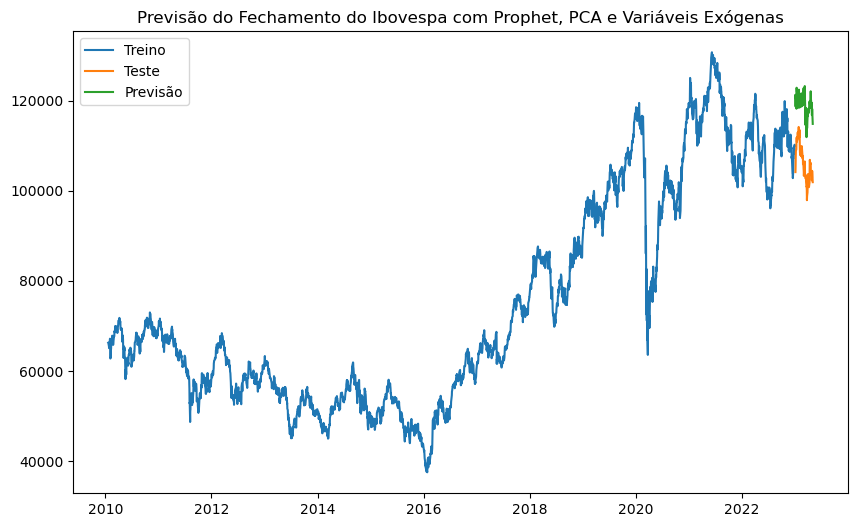

In [2]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Função para calcular o RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Baixar dados do Ibovespa e outras variáveis
ibov = yf.download('^BVSP', start='2010-01-01', end='2023-07-08')['Close']
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-07-08')['Close']  # S&P 500
usd_brl = yf.download('BRL=X', start='2010-01-01', end='2023-07-08')['Close']  # Taxa de câmbio USD/BRL
oil = yf.download('CL=F', start='2010-01-01', end='2023-07-08')['Close']  # Preço do petróleo

# Criar um DataFrame com o índice de datas comuns
dates = ibov.index

# Reindexar todas as séries para ter as mesmas datas
sp500 = sp500.reindex(dates)
usd_brl = usd_brl.reindex(dates)
oil = oil.reindex(dates)

# Calcular o RSI para o Ibovespa
rsi_ibov = calculate_rsi(ibov, 14).reindex(dates)

# Criar novas features de variação percentual
sp500_pct = sp500.pct_change().fillna(0)
usd_brl_pct = usd_brl.pct_change().fillna(0)
oil_pct = oil.pct_change().fillna(0)

# Combinar dados em um único DataFrame
data = pd.DataFrame({
    'ds': dates,
    'y': ibov.values,
    'SP500': sp500.values,
    'USD/BRL': usd_brl.values,
    'Oil': oil.values,
    'RSI_Ibov': rsi_ibov.values,
    'SP500_pct': sp500_pct.values,
    'USD/BRL_pct': usd_brl_pct.values,
    'Oil_pct': oil_pct.values
})

# Remover valores nulos
data = data.dropna()

# Normalizar variáveis exógenas
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['SP500', 'USD/BRL', 'Oil', 'RSI_Ibov', 'SP500_pct', 'USD/BRL_pct', 'Oil_pct']])

# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_data)

# Adicionar os componentes principais ao DataFrame
data['PCA1'] = pca_features[:, 0]
data['PCA2'] = pca_features[:, 1]
data['PCA3'] = pca_features[:, 2]

# Dividir dados em treino e teste
train = data[data['ds'] <= '2022-12-31']
test = data[data['ds'] > '2022-12-31']

# Ajustar o modelo Prophet com variáveis exógenas e componentes principais
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)
model.add_regressor('PCA1')
model.add_regressor('PCA2')
model.add_regressor('PCA3')

# Treinar o modelo
model.fit(train)

# Fazer previsões
future = model.make_future_dataframe(periods=len(test))
future['PCA1'] = data['PCA1'].reset_index(drop=True)
future['PCA2'] = data['PCA2'].reset_index(drop=True)
future['PCA3'] = data['PCA3'].reset_index(drop=True)
forecast = model.predict(future)

# Alinhar as previsões com o período de teste, garantindo datas comuns
forecast_test = forecast[forecast['ds'].isin(test['ds'])].set_index('ds')
test = test.set_index('ds')
common_dates = test.index.intersection(forecast_test.index)
aligned_forecast = forecast_test.loc[common_dates]
aligned_test = test.loc[common_dates]

# Calcular métricas de acurácia
mae = mean_absolute_error(aligned_test['y'], aligned_forecast['yhat'])
mse = mean_squared_error(aligned_test['y'], aligned_forecast['yhat'])
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Treino')
plt.plot(aligned_test.index, aligned_test['y'], label='Teste')
plt.plot(aligned_forecast.index, aligned_forecast['yhat'], label='Previsão')
plt.legend()
plt.title('Previsão do Fechamento do Ibovespa com Prophet, PCA e Variáveis Exógenas')
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_29818/2190855337.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_pct = sp500.pct_change().fillna(0)
/tmp/ipykernel_29818/2190855337.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  usd_brl_pct = usd_brl.pct_change().fillna(0)
/tmp/ipykernel_29818/2190855337.py:37: FutureWarning: The default fill

MAE: 7245.927386959037
MSE: 69838306.11985743
RMSE: 8356.931621106962
Acurácia Percentual: 93.18%


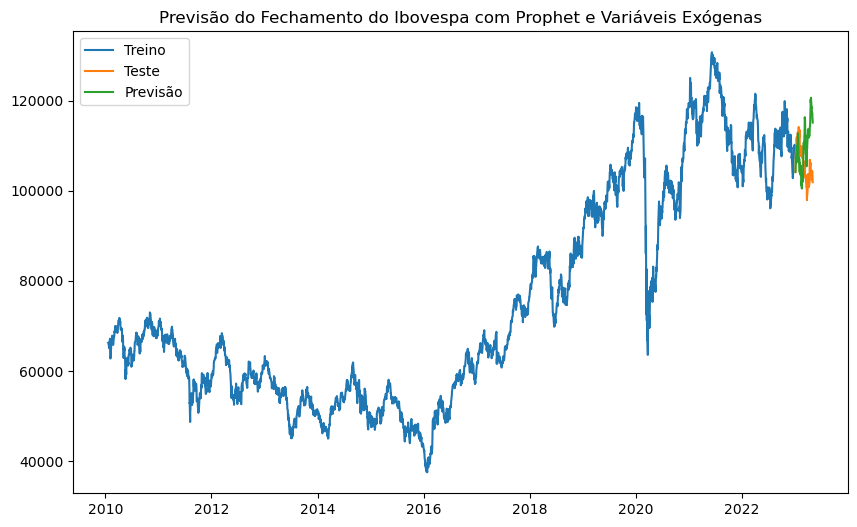

In [3]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular o RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Baixar dados do Ibovespa e outras variáveis
ibov = yf.download('^BVSP', start='2010-01-01', end='2023-07-08')['Close']
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-07-08')['Close']  # S&P 500
usd_brl = yf.download('BRL=X', start='2010-01-01', end='2023-07-08')['Close']  # Taxa de câmbio USD/BRL
oil = yf.download('CL=F', start='2010-01-01', end='2023-07-08')['Close']  # Preço do petróleo

# Criar um DataFrame com o índice de datas comuns
dates = ibov.index

# Reindexar todas as séries para ter as mesmas datas
sp500 = sp500.reindex(dates)
usd_brl = usd_brl.reindex(dates)
oil = oil.reindex(dates)

# Calcular o RSI para o Ibovespa
rsi_ibov = calculate_rsi(ibov, 14).reindex(dates)

# Criar novas features de variação percentual
sp500_pct = sp500.pct_change().fillna(0)
usd_brl_pct = usd_brl.pct_change().fillna(0)
oil_pct = oil.pct_change().fillna(0)

# Combinar dados em um único DataFrame
data = pd.DataFrame({
    'ds': dates,
    'y': ibov.values,
    'SP500': sp500.values,
    'USD/BRL': usd_brl.values,
    'Oil': oil.values,
    'RSI_Ibov': rsi_ibov.values,
    'SP500_pct': sp500_pct.values,
    'USD/BRL_pct': usd_brl_pct.values,
    'Oil_pct': oil_pct.values
})

# Remover valores nulos
data = data.dropna()

# Dividir dados em treino e teste
train = data[data['ds'] <= '2022-12-31']
test = data[data['ds'] > '2022-12-31']

# Ajustar o modelo Prophet com variáveis exógenas
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)
model.add_regressor('SP500')
model.add_regressor('USD/BRL')
model.add_regressor('Oil')
model.add_regressor('RSI_Ibov')
model.add_regressor('SP500_pct')
model.add_regressor('USD/BRL_pct')
model.add_regressor('Oil_pct')

# Treinar o modelo
model.fit(train)

# Fazer previsões
future = model.make_future_dataframe(periods=len(test))
future['SP500'] = data['SP500'].reset_index(drop=True)
future['USD/BRL'] = data['USD/BRL'].reset_index(drop=True)
future['Oil'] = data['Oil'].reset_index(drop=True)
future['RSI_Ibov'] = data['RSI_Ibov'].reset_index(drop=True)
future['SP500_pct'] = data['SP500_pct'].reset_index(drop=True)
future['USD/BRL_pct'] = data['USD/BRL_pct'].reset_index(drop=True)
future['Oil_pct'] = data['Oil_pct'].reset_index(drop=True)
forecast = model.predict(future)

# Alinhar as previsões com o período de teste, garantindo datas comuns
forecast_test = forecast[forecast['ds'].isin(test['ds'])].set_index('ds')
test = test.set_index('ds')
common_dates = test.index.intersection(forecast_test.index)
aligned_forecast = forecast_test.loc[common_dates]
aligned_test = test.loc[common_dates]

# Calcular métricas de acurácia
mae = mean_absolute_error(aligned_test['y'], aligned_forecast['yhat'])
mse = mean_squared_error(aligned_test['y'], aligned_forecast['yhat'])
rmse = np.sqrt(mse)

# Calcular a acurácia percentual
valor_medio_real = aligned_test['y'].mean()
acuracia_percentual = 100 * (1 - mae / valor_medio_real)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'Acurácia Percentual: {acuracia_percentual:.2f}%')

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Treino')
plt.plot(aligned_test.index, aligned_test['y'], label='Teste')
plt.plot(aligned_forecast.index, aligned_forecast['yhat'], label='Previsão')
plt.legend()
plt.title('Previsão do Fechamento do Ibovespa com Prophet e Variáveis Exógenas')
plt.show()